# Tweet Turing Test: Detecting Disinformation on Twitter  

|          | Group #2 - Disinformation Detectors                     |
|---------:|---------------------------------------------------------|
| Members  | John Johnson, Katy Matulay, Justin Minnion, Jared Rubin |
| Notebook | `03_eda.ipynb`                                          |
| Purpose  | Conduct EDA of pre-processed data.                      |

> (TODO - write more explaining notebook)

# 1 - Setup

In [1]:
# imports from Python standard library
import json
import logging
import os

# imports requiring installation
#   connection to Google Cloud Storage
from google.cloud import storage            # pip install google-cloud-storage
from google.oauth2 import service_account   # pip install google-auth

#  data science packages
import demoji                               # pip install demoji
import numpy as np                          # pip install numpy
import pandas as pd                         # pip install pandas
import matplotlib.pyplot as plt             # pip install matplotlib
#from matplotlib import rcParams             
import seaborn as sns                       # pip install seaborn
# import plotly.express as px                 # pip install plotly==5.11.0

In [2]:
# imports from tweet_turing.py
import tweet_turing as tur      # note - different import approach from prior notebooks

# imports from tweet_turing_paths.py
from tweet_turing_paths import local_data_paths, local_snapshot_paths, gcp_data_paths, \
    gcp_snapshot_paths, gcp_project_name, gcp_bucket_name, gcp_key_file

In [3]:
# pandas options
pd.set_option('display.max_colwidth', None)

# seaborn options
sns.set_theme(context='paper', style='ticks', palette='bright', font='Arial', rc={'figure.dpi': 200})
twitter_colors = {
    'blue': r"#1DA1F2",     # source: https://usbrandcolors.com/twitter-colors/
    'black': r"#14171A",
    'dark gray': r"#657786",
    'dark blue': r"#0f5580" # "blue" with brightness changed 88% to 50%, non-standard color
    }

## Local or Cloud?

Decide here whether to run notebook with local data or GCP bucket data
 - if the working directory of this notebook has a "../data/" folder with data loaded (e.g. working on local computer or have data files loaded to a cloud VM) then use the "local files" option and comment out the "gcp bucket files" option
 - if this notebook is being run from a GCP VM (preferrably in the `us-central1` location) then use the "gcp bucket files" option and comment out the "local files" option

In [4]:
# option: local files
local_or_cloud: str = "local"   # comment/uncomment this line or next

# option: gcp bucket files
#local_or_cloud: str = "cloud"   # comment/uncomment this line or previous

# don't comment/uncomment for remainder of cell
if (local_or_cloud == "local"):
    data_paths = local_data_paths
    snapshot_paths = local_snapshot_paths
elif (local_or_cloud == "cloud"):
    data_paths = gcp_data_paths
    snapshot_paths = gcp_snapshot_paths
else:
    raise ValueError("Variable 'local_or_cloud' can only take on one of two values, 'local' or 'cloud'.")
    # subsequent cells will not do this final "else" check

In [5]:
# this cell only needs to run its code if local_or_cloud=="cloud"
#   (though it is harmless if run when local_or_cloud=="local")
gcp_storage_client: storage.Client = None
gcp_bucket: storage.Bucket = None

if (local_or_cloud == "cloud"):
    gcp_storage_client = tur.get_gcp_storage_client(project_name=gcp_project_name, key_file=gcp_key_file)
    gcp_bucket = tur.get_gcp_bucket(storage_client=gcp_storage_client, bucket_name=gcp_bucket_name)

# 2 - Load dataset

In [6]:
# note this cell requires package `pyarrow` to be installed in environment
parq_filename: str = "merged_df_preprocessed.parquet.snappy"
parq_path: str = f"{snapshot_paths['parq_snapshot']}{parq_filename}"

if (local_or_cloud == "local"):
    merged_df = pd.read_parquet(parq_path, engine='pyarrow')
elif (local_or_cloud == "cloud"):
    pass

# 3 - EDA Basics

Display basic pandas info, showing number of entries, columns (and their dtypes) within dataframe, and memory usage.

In [7]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3624894 entries, 0 to 3624893
Data columns (total 18 columns):
 #   Column              Dtype              
---  ------              -----              
 0   external_author_id  string             
 1   author              string             
 2   content             string             
 3   region              string             
 4   language            string             
 5   following           uint64             
 6   followers           uint64             
 7   updates             uint64             
 8   post_type           string             
 9   is_retweet          float64            
 10  account_category    string             
 11  tweet_id            string             
 12  tco1_step1          string             
 13  data_source         string             
 14  has_url             int64              
 15  emoji_text          object             
 16  emoji_count         int64              
 17  publish_date        datetim

See a few sample rows:

In [8]:
merged_df.sample(2)

,external_author_id,author,content,region,language,following,followers,updates,post_type,is_retweet,account_category,tweet_id,tco1_step1,data_source,has_url,emoji_text,emoji_count,publish_date
2145889,7152572,librarycongress,"ICYMI: Pic of the Week for last Friday featured Wonder Woman Visiting the Library for ""Library of Awesome."" https://t.co/0IUxHWUwwZ https://t.co/AqCpggZ13s","Washington, DC",en,13,1265906,164,<NA>,0.0,Verified_User,876862157668835328,http://blogs.loc.gov/loc/2017/06/pic-of-the-week-wonder-woman-visits-the-library/?loclr=twloc,verified_user,1,[],0,2017-06-19 18:00:04+00:00
2040433,1666030405,PAMBLMDANIELS,Now Playing: Firewater Redstarr - How We Ride -&gt; https://t.co/eMX9JgTv3v,United States,English,544,1018,6545,RETWEET,1.0,LeftTroll,817303646736187392,http://1063.mobi,Troll,1,[],0,2017-01-06 09:35:00+00:00


Examine nulls / missing values.

In [9]:
merged_df.isnull().sum()

external_author_id          0
author                      0
content                     0
region                 180192
language                    0
following                   0
followers                   0
updates                     0
post_type             2084245
is_retweet                  0
account_category            0
tweet_id                    0
tco1_step1            1427061
data_source                 0
has_url                     0
emoji_text                  0
emoji_count                 0
publish_date                0
dtype: int64

## 3.1 Additional Pre-processing

As needed, a few additional pre-processing steps are added to this section to aid with subsequent EDA sections.

### 3.1.1 Troll / Verified Label

Our `data_source` feature is close to being a differentiator of our target classes of Troll / Authentic. Feature `data_source` contains values below:

In [47]:
merged_df['data_source'].value_counts(dropna=False)

Troll              2116866
verified_random    1070661
verified_user       437367
Name: data_source, dtype: Int64

We will combine the tweets with `data_source` values *verified_random* and *verified_user* into a single *Verified* label, and store the result in a new column.

In [48]:
data_source_mapping = {
    'Troll': 'Troll', 
    'verified_user': 'Verified', 
    'verified_random': 'Verified'
    }

merged_df['class'] = merged_df['data_source'].map(data_source_mapping)

merged_df['class'].value_counts(dropna=False)

Troll       2116866
Verified    1508028
Name: class, dtype: int64

# 4 - Features (Individual Analysis)

The table below provides a description of the features we have in our dataset to this point.

> (note to team: using https://www.tablesgenerator.com/markdown_tables# to generate markdown for this table)

| **Feature** | **Description** | **NOIR Type** | **Notes** |
|:---:|---|:---:|---|
| `external_author_id` | Author ID | Nominal | Unique identifier / primary key for twitter accounts |
| `author` | Author Twitter Handle | Nominal | The Twitter handle (i.e. username) of this tweet's author |
| `content` | Tweet Content |  | The text of the tweet itself, including hashtags, hyperlinks, mentions, etc. |
| `region` | Region | Nominal | A region classification. For troll tweets, determined by [Social Studio (link: help.salesforce.com)](https://help.salesforce.com/articleView?id=000199367&type=1) |
| `language` | Language | Nominal | The language of the tweet |
| `following` | Number of Other Accounts Followed | Ratio |  |
| `followers` | Number of Other Accounts Following | Ratio |  |
| `updates` | Number of Update Actions | Ratio | A composite measurement of public metrics for interaction by other users with a tweet. |
| `is_retweet` | Retweet |  | Binary indicator of whether or not the tweet is a retweet. |
| `account_category` | Account Category | Nominal |  |
| `tweet_id` | Tweet ID | Nominal | Unique identifier for each tweet, assigned by Twitter. |
| `tco1_step1` | First URL from within Tweet Content | Nominal |  |
| `data_source` | Data Source | Nominal |  |
| `is_retweet_alt` | Retweet (Alternate) |  |  |
| `has_url` | Tweet Has URL |  |  |
| `emoji_text` | Emoji Text |  | A list of natural language descriptions of each unique emoji used. |
| `emoji_count` | Number of Emoji | Ratio |  |
| `publish_date` | Publish Date of Tweet | Interval |  |

## 4.1 - Author ID (`external_author_id`)

We did not conduct extensive individual analysis of this feature because it is an auto-generated value set by Twitter.  

Some additional thoughts:

 - Because these numbers are randomly generated, the magnitude of the ID could not be used as a proxy for account age.
 - Twitter uses a 64-bit integer for this ID and recommends handling them as strings to avoid loss of precision among various implementations of an int64-like type.
 - One possible analysis (coupled with `author`) would be to determine how many values of `author` correspond to a given `external_author_id`. This would potentially indicate a user who changes their Twitter handle more often than average. This would be a great candidate for a map/reduce aggregation task. To collect this data on a large scale would require a *huge* volume of data, though, so we do not plan to attempt it for our project.

## 4.2 - Author Twitter Handle (`author`)

We can examine which Twitter handles are most represented in the dataset (and peek at their account category).

In [11]:
# map: create tuples of (author, account_category)
author_tuples = merged_df.apply(lambda row: (row['author'], row['account_category']), axis='columns')

# reduce: count tuple occurrences and sort
author_tuple_counts = author_tuples.value_counts(ascending=False)

In [12]:
# display top results
pd.concat(
    [
        pd.DataFrame.from_records(
            author_tuple_counts.index, 
            index=author_tuple_counts.index, 
            columns=['author', 'account_category']
            )
        , 
        pd.DataFrame(
            author_tuple_counts.values,
            index=author_tuple_counts.index,
            columns=['count']
            )
    ], 
    axis=1, 
    ).nlargest(20, columns=['count'])

,author,account_category,count
"(EXQUOTE, Commercial)",EXQUOTE,Commercial,53158
"(AskTSA, Verified_User)",AskTSA,Verified_User,49390
"(SCREAMYMONKEY, NewsFeed)",SCREAMYMONKEY,NewsFeed,43956
"(WORLDNEWSPOLI, RightTroll)",WORLDNEWSPOLI,RightTroll,35082
"(AMELIEBALDWIN, RightTroll)",AMELIEBALDWIN,RightTroll,34308
"(TODAYPITTSBURGH, NewsFeed)",TODAYPITTSBURGH,NewsFeed,33377
"(SPECIALAFFAIR, NewsFeed)",SPECIALAFFAIR,NewsFeed,32416
"(SEATTLE_POST, NewsFeed)",SEATTLE_POST,NewsFeed,30680
"(KANSASDAILYNEWS, NewsFeed)",KANSASDAILYNEWS,NewsFeed,28746
"(ROOMOFRUMOR, NewsFeed)",ROOMOFRUMOR,NewsFeed,28259


How many unique Twitter handles are in our dataset?

In [13]:
print(f"Number of unique Twitter handles:\t{merged_df['author'].nunique():,} unique handles")

Number of unique Twitter handles:	142,270 unique handles


## 4.3 - Tweet Content (`content`)

### 4.3.1 - Tweet Length (characters)

First analyzed by Python's built-in `len()` function. What we see is a large spike at $len=140$, but an odd trail of values over $len=900$.

In [50]:
tweet_lengths: pd.DataFrame = merged_df[['content', 'class']].copy()
tweet_lengths['length'] = tweet_lengths['content'].apply(len)

n_140char = tweet_lengths.loc[tweet_lengths['length'] == 140, 'length'].count()
n_280char = tweet_lengths.loc[tweet_lengths['length'] == 280, 'length'].count()

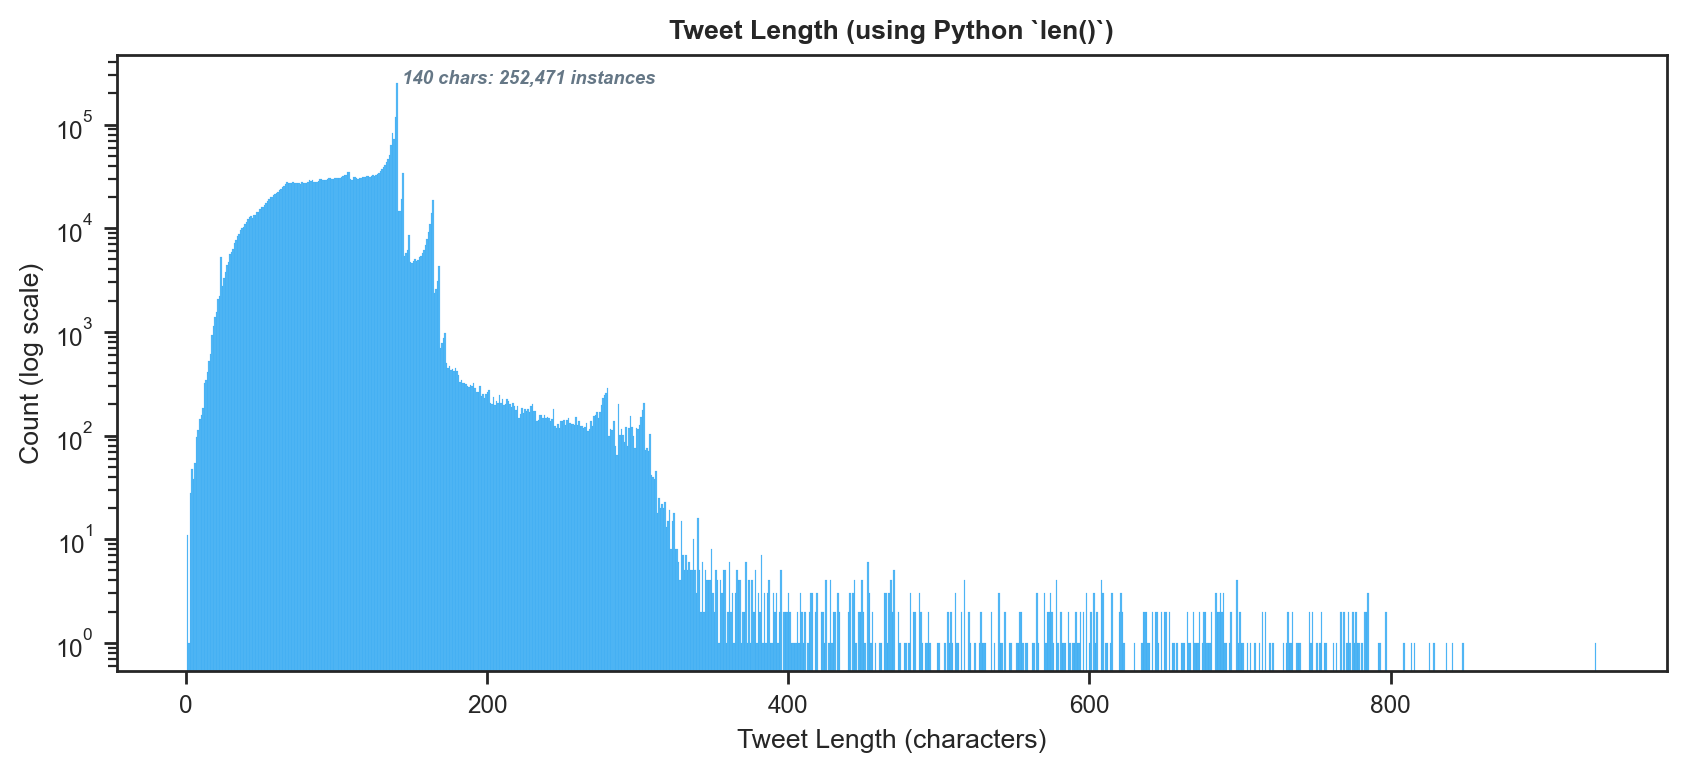

In [51]:
fig, ax = plt.subplots(figsize=(10,4))

ax.set_yscale('log')
ax.set_title("Tweet Length (using Python `len()`)", weight='bold')
ax.set_xlabel("Tweet Length (characters)")
ax.set_ylabel("Count (log scale)")

sns.histplot(tweet_lengths, 
                x='length', 
                color=twitter_colors['blue'], 
                edgecolor=twitter_colors['blue'],
                discrete=True, 
                ax=ax
            )

plt.text(x=140, y=n_140char, s=f" 140 chars: {n_140char:,} instances", 
            size='x-small', weight='semibold', style='italic', alpha=1.0, color=twitter_colors['dark gray'])

plt.show()

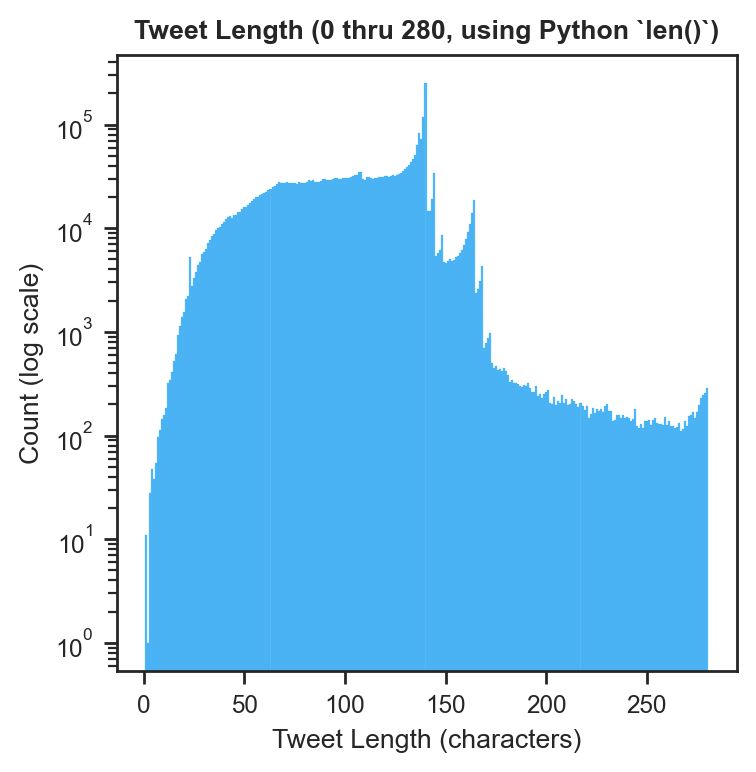

In [52]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_yscale('log')
ax.set_title("Tweet Length (0 thru 280, using Python `len()`)", weight='bold')
ax.set_xlabel("Tweet Length (characters)")
ax.set_ylabel("Count (log scale)")

sns.histplot(tweet_lengths.loc[tweet_lengths['length'].between(0, 280, inclusive='both')], 
                x='length', 
                color=twitter_colors['blue'],
                edgecolor=twitter_colors['blue'], 
                discrete=True, 
                ax=ax
            )

plt.show()

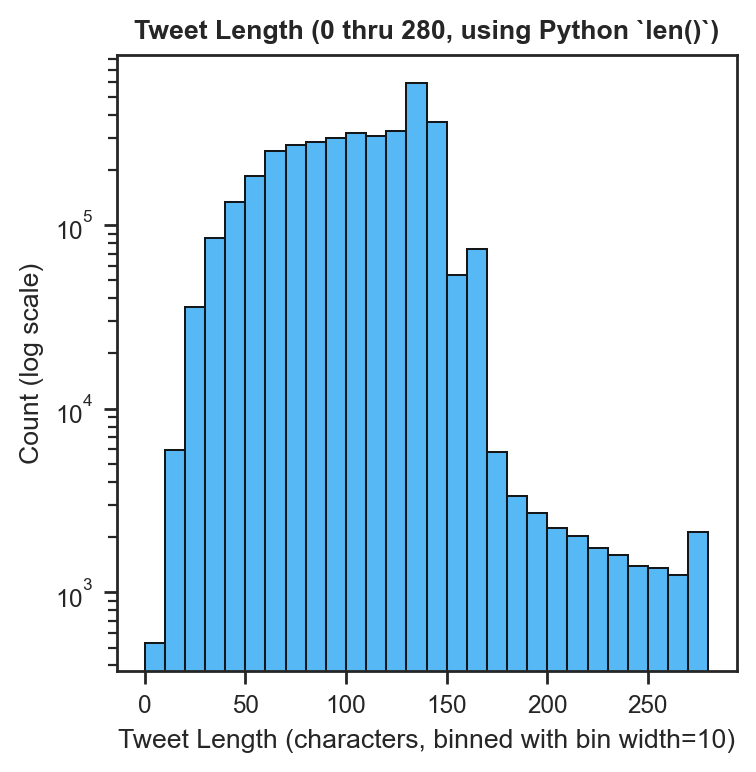

In [53]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_yscale('log')
ax.set_title("Tweet Length (0 thru 280, using Python `len()`)", weight='bold')
ax.set_xlabel("Tweet Length (characters, binned with bin width=10)")
ax.set_ylabel("Count (log scale)")

sns.histplot(tweet_lengths.loc[tweet_lengths['length'].between(0, 280, inclusive='both')], 
                x='length', 
                color=twitter_colors['blue'], 
                bins=28,
                binrange=(0, 280),
                element='bars',
                edgecolor=twitter_colors['black'],
                ax=ax
            )

plt.show()

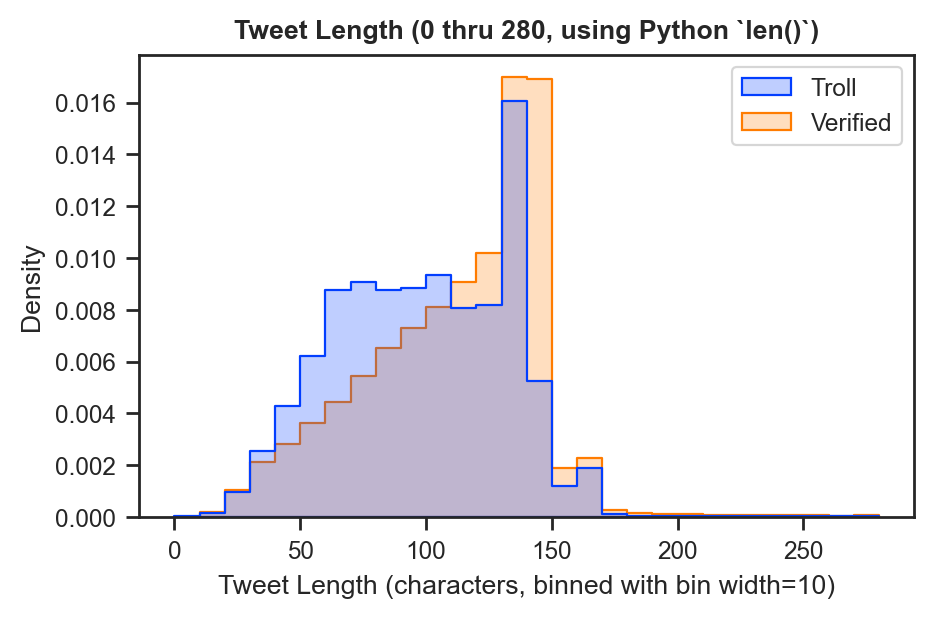

In [56]:
fig, ax = plt.subplots(figsize=(5,3))

ax.set_title("Tweet Length (0 thru 280, using Python `len()`)", weight='bold')
ax.set_xlabel("Tweet Length (characters, binned with bin width=10)")
ax.set_ylabel("Density")

sns.histplot(tweet_lengths.loc[tweet_lengths['length'].between(0, 280, inclusive='both')], 
                x='length', 
                hue='class',
                bins=28,
                binrange=(0, 280),
                element='step',
                stat='density',
                common_norm=False,
                ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

The manner in which Twitter validates a tweet's length involves a decent amount of complexity, but boils down to that certain elements (emoji, shortened URLs) have a fixed value for number of characters. Twitter provides an open-source library showing how this character counting method but not in Python (available languages are Java, Javascript/Node.js, Ruby, and Objective-C). An external package `tweet-counter` approximates this character counting method in Python (*package source: [[github.com]](https://github.com/nottrobin/tweet-counter)*).

In [57]:
tweet_lengths['length_twitter'] = tweet_lengths.apply(tur.char_count, axis='columns')

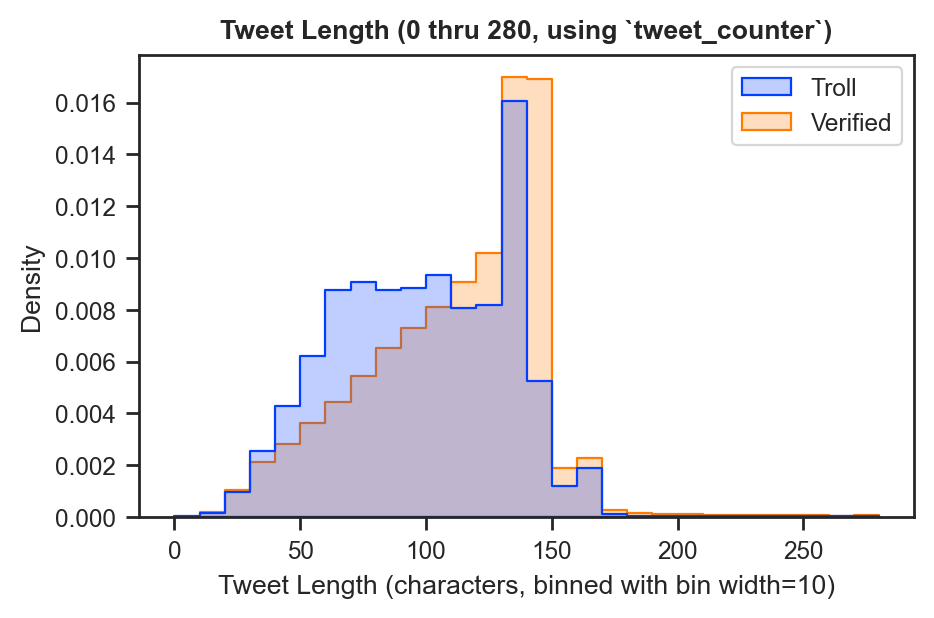

In [59]:
fig, ax = plt.subplots(figsize=(5,3))

ax.set_title("Tweet Length (0 thru 280, using `tweet_counter`)", weight='bold')
ax.set_xlabel("Tweet Length (characters, binned with bin width=10)")
ax.set_ylabel("Density")

sns.histplot(tweet_lengths.loc[tweet_lengths['length_twitter'].between(0, 280, inclusive='both')], 
                x='length', 
                hue='class',
                bins=28,
                binrange=(0, 280),
                element='step',
                stat='density',
                common_norm=False,
                ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

Qualitatively it doesn't appear there is a sensible difference between the two counting methods. We can stack the histograms for a better view.

In [60]:
# unpivot the dataframe into long form
tweet_lengths_melted = pd.melt(
    tweet_lengths, 
    id_vars=['class'], 
    value_vars=['length', 'length_twitter'],
    var_name='length_method',
    value_name='length_value',
    ignore_index=False
    ).replace(
        {'length_method': {
                'length': 'Python `len`',
                'length_twitter': '`tweet_counter`'
            }
        }
    )

In [61]:
# check long form results
tweet_lengths_melted.loc[0]

,class,length_method,length_value
0,Troll,Python `len`,156
0,Troll,`tweet_counter`,156


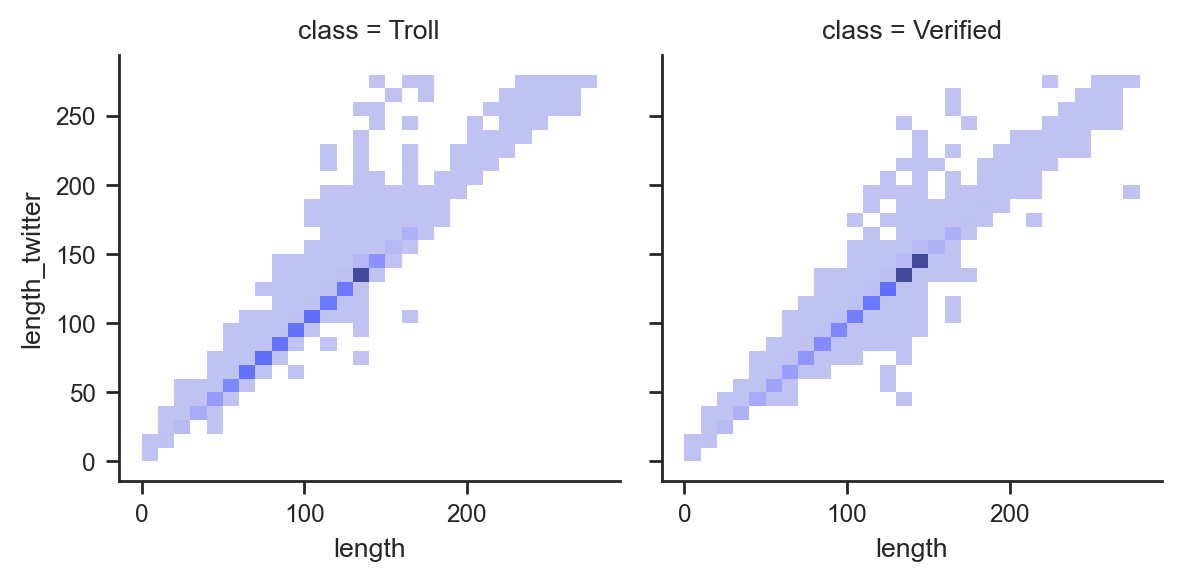

In [63]:
g = sns.FacetGrid(tweet_lengths, col='class')
g.map(sns.histplot, 'length', 'length_twitter', bins=28, binrange=(0,280), stat='density', common_norm=False)

plt.show()

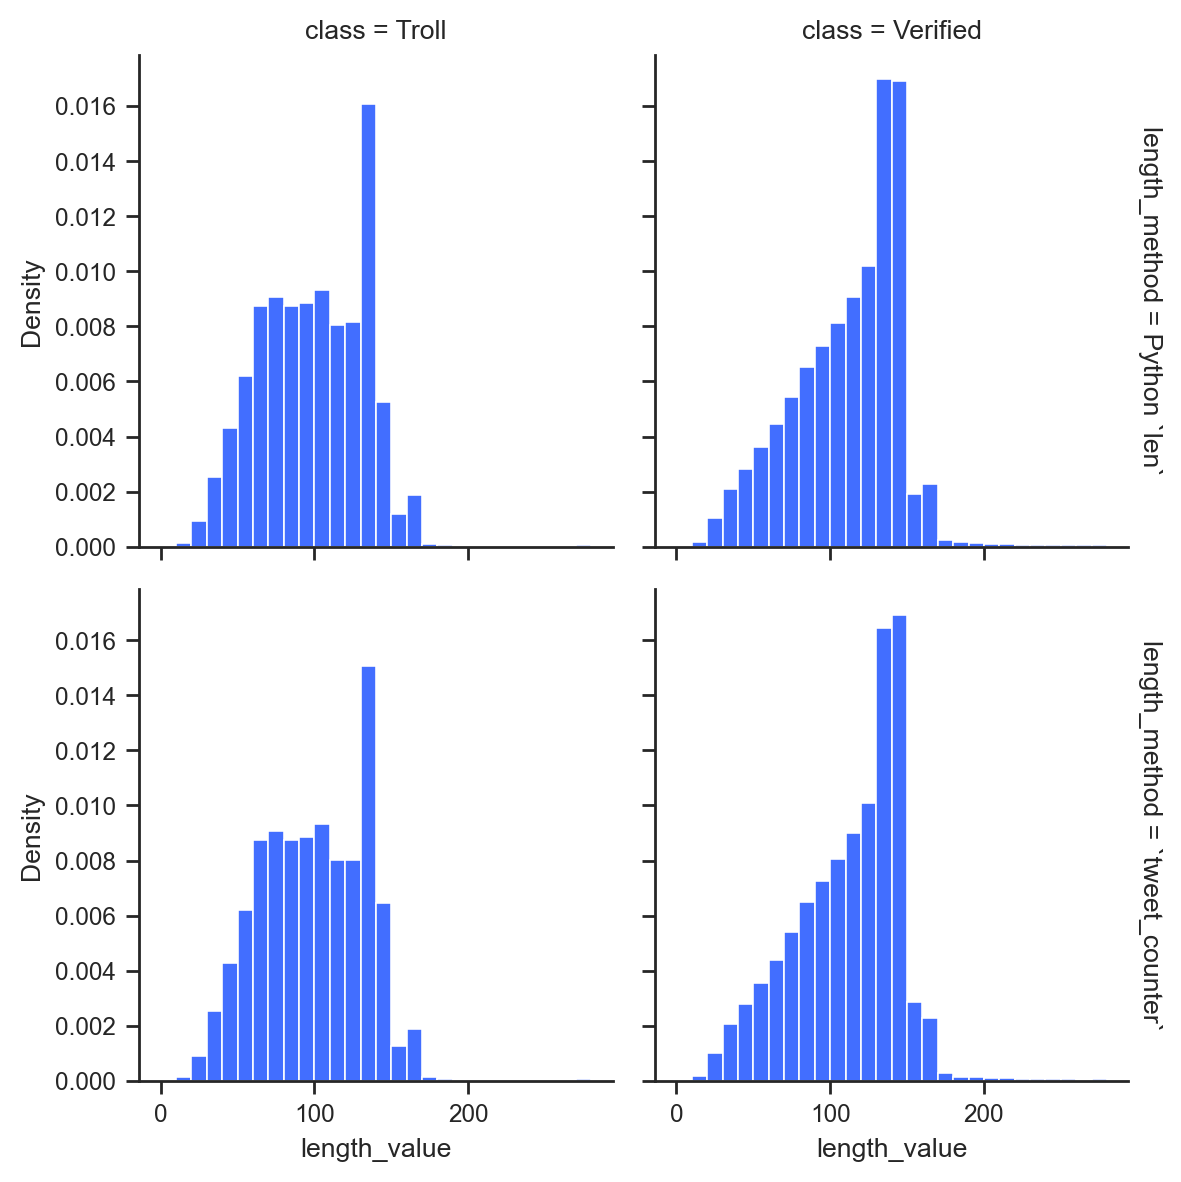

In [64]:
g = sns.FacetGrid(tweet_lengths_melted, row='length_method', col='class', margin_titles=True)
g.map(sns.histplot, 'length_value', bins=28, binrange=(0,280), stat='density', common_norm=False)

plt.show()

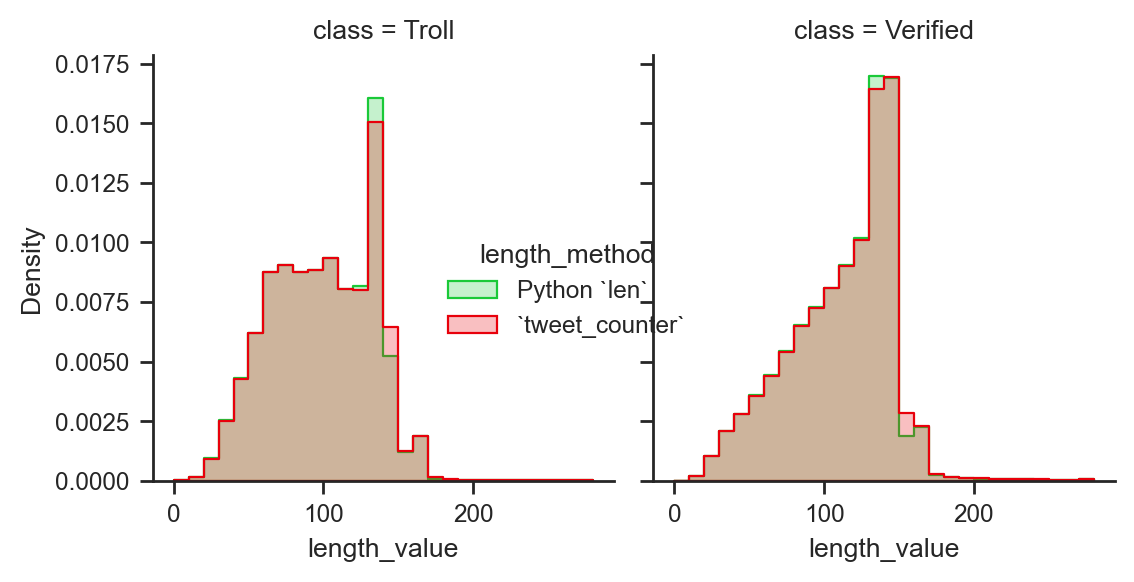

In [65]:
g = sns.FacetGrid(tweet_lengths_melted, 
                    hue='length_method', 
                    col='class', 
                    margin_titles=True, 
                    palette=sns.color_palette()[2:4]
                )
g.map(sns.histplot, 'length_value', 
        bins=28, 
        binrange=(0,280), 
        stat='density', 
        common_norm=False, 
        element='step', 
        alpha=0.25
    )

g.add_legend(loc='center')  # TODO: need to position legend better

plt.show()

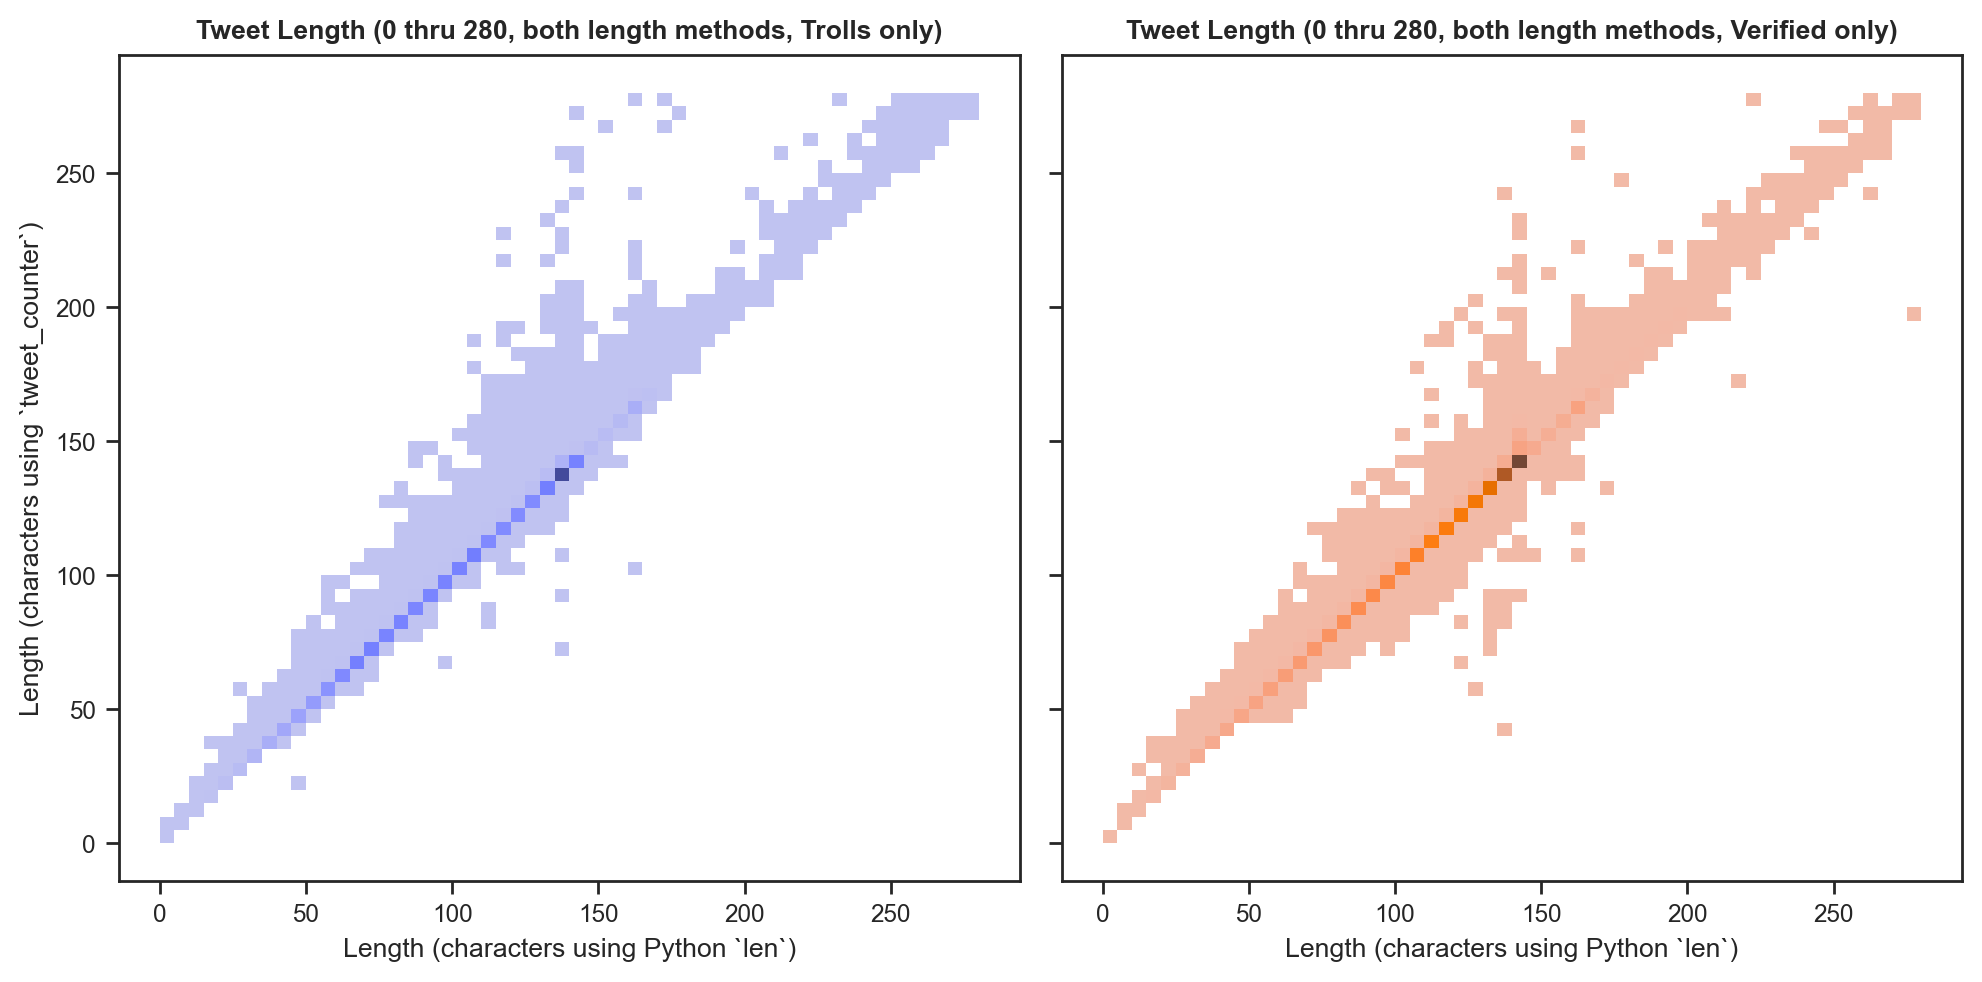

In [195]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True, layout="tight")

ax[0].set_title("Tweet Length (0 thru 280, both length methods, Trolls only)", weight='bold')
ax[0].set_xlabel("Length (characters using Python `len`)")
ax[0].set_ylabel("Length (characters using `tweet_counter`)")

ax[1].set_title("Tweet Length (0 thru 280, both length methods, Verified only)", weight='bold')
ax[1].set_xlabel("Length (characters using Python `len`)")

sns.histplot(tweet_lengths.loc[(tweet_lengths['length'].between(0,280)) & (tweet_lengths['class'] == 'Troll')],
                x='length',
                y='length_twitter',
                color=sns.color_palette()[0],
                bins=28*2,
                binrange=(0,280),
                stat='density',
                common_norm=False,
                ax=ax[0]
            )

sns.histplot(tweet_lengths.loc[(tweet_lengths['length'].between(0,280)) & (tweet_lengths['class'] == 'Verified')],
                x='length',
                y='length_twitter',
                color=sns.color_palette()[1],
                bins=28*2,
                binrange=(0,280),
                stat='density',
                common_norm=False,
                ax=ax[1]
            )

plt.show()

> TODO - what is up with tweets of length >280? 900 characters?

## 4.4 - Region (`region`)

In [67]:
# determine number of unique values
print(f"Unique `region` values: {len(merged_df['region'].unique().tolist()):,}")

Unique `region` values: 35,447


In [68]:
region_n_largest: pd.Series = merged_df.value_counts(subset='region', ascending=False).nlargest(15)

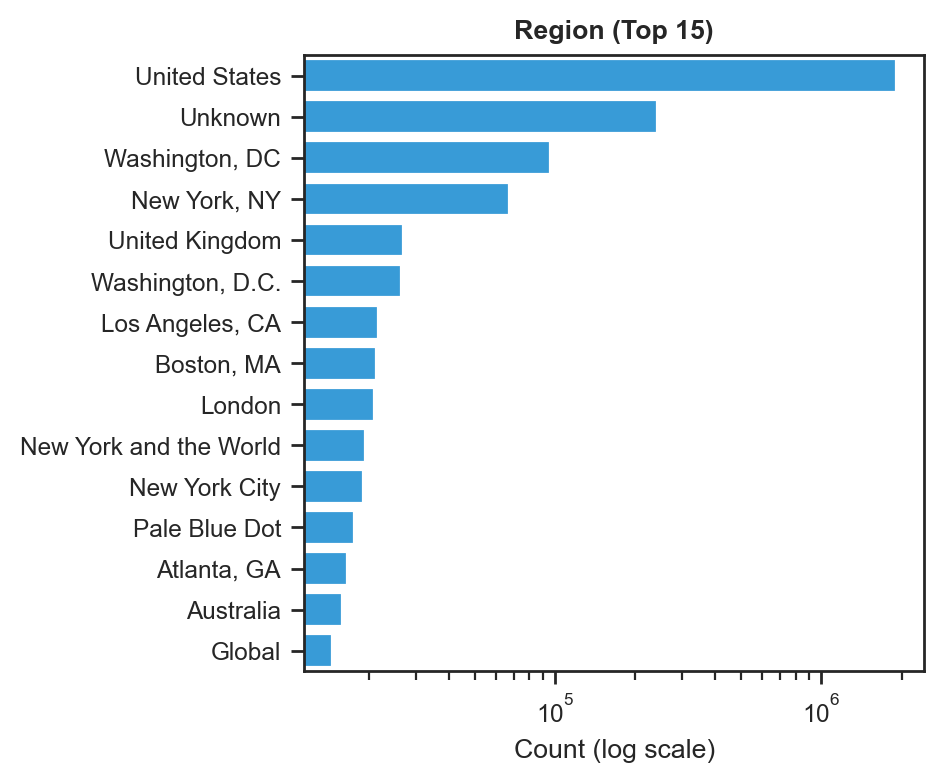

In [69]:
fig, ax = plt.subplots(figsize=(4,4))

sns.barplot(x=region_n_largest.values, 
            y=region_n_largest.index, 
            color=twitter_colors['blue'],
            ax=ax
            )

ax.set_xscale('log')
ax.set_title("Region (Top 15)", weight='bold')
ax.set_xlabel("Count (log scale)")
ax.set_ylabel(None)

plt.show()

In [84]:
region_df = merged_df[['region', 'data_source', 'class']].copy()

In [85]:
region_n_largest_df = region_df.loc[
                            region_df['region'].isin(region_n_largest.index), :
                        ].groupby(
                            by=['region', 'class']
                        ).count().rename(columns={'data_source': 'count'}).reset_index()

region_n_largest_df.head()

,region,class,count
0,"Atlanta, GA",Verified,16580
1,Australia,Verified,15804
2,"Boston, MA",Verified,21310
3,Global,Verified,14590
4,London,Verified,20968


In [106]:
region_n_largest_troll = region_df.loc[
                            region_df['class'] == "Troll"
                        ].groupby(
                            by=['region', 'class']
                        ).count().rename(columns={'data_source': 'count'}).reset_index().nlargest(15, columns='count')

region_n_largest_verif = region_df.loc[
                            region_df['class'] == "Verified"
                        ].groupby(
                            by=['region', 'class']
                        ).count().rename(columns={'data_source': 'count'}).reset_index().nlargest(15, columns='count')

region_n_largest_joined = pd.concat(
                            [region_n_largest_verif, region_n_largest_troll], 
                            ignore_index=True
                        ).sort_values(by='count')

,region,class,count
29,Spain,Troll,72
28,Ukraine,Troll,146
27,United Arab Emirates,Troll,370
26,Israel,Troll,409
25,Iraq,Troll,427
24,Belarus,Troll,449
23,Afghanistan,Troll,461
22,Canada,Troll,600
21,Italy,Troll,1125
20,Russian Federation,Troll,1145


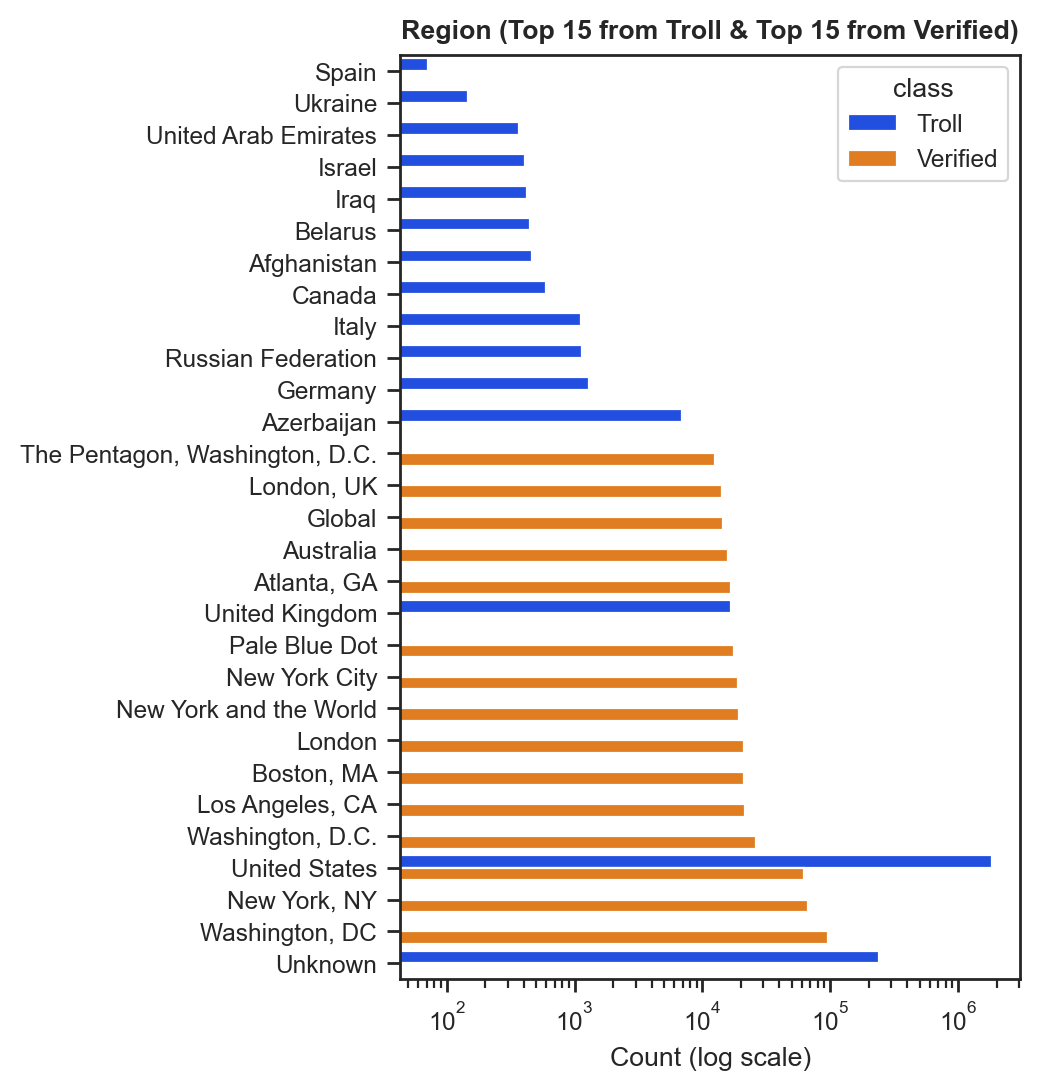

In [196]:
fig, ax = plt.subplots(figsize=(4,6))

sns.barplot(region_n_largest_joined,
            x='count', 
            y='region', 
            hue='class',
            hue_order=['Troll', 'Verified'],
            ax=ax
            )

ax.set_xscale('log')
ax.set_title("Region (Top 15 from Troll & Top 15 from Verified)", weight='bold')
ax.set_xlabel("Count (log scale)")
ax.set_ylabel(None)

plt.show()

## 4.5 - Language (`language`)

How many unique languages are contained within our dataset?

In [109]:
print(f"Number of unique languages:\t{merged_df['language'].nunique():,} unique languages")

Number of unique languages:	29 unique languages


In [110]:
merged_df['language'].unique().tolist()

['en',
 'fr',
 'da',
 'de',
 'in',
 'it',
 'tl',
 'es',
 'pt',
 'ca',
 'cy',
 'nl',
 'pl',
 'zxx',
 'et',
 'no',
 'ht',
 'eu',
 'tr',
 'ro',
 'sv',
 'lv',
 'lt',
 'vi',
 'hi',
 'cs',
 'und',
 'ko',
 'hu']

### 4.5.1 - Combining English and en

In [111]:
merged_df['language'] = merged_df['language'].apply(lambda x: 'en' if x == 'English' else x)

The vast majority of our dataset are labeled with language "`en`" for English.

In [112]:
merged_df['language'].value_counts(ascending=False, dropna=False)

en     3623140
fr         397
tl         308
es         304
de         157
nl         117
in          83
pt          65
it          58
da          56
et          48
ht          43
eu          24
ca          18
sv          16
no          13
pl          12
cy          12
tr           4
lt           4
vi           4
lv           3
hu           2
ro           1
zxx          1
hi           1
cs           1
und          1
ko           1
Name: language, dtype: int64

In [113]:
print(f"Number of unique languages:\t{merged_df['language'].nunique():,} unique languages")

Number of unique languages:	29 unique languages


## 4.6 - Number of Accounts Following (`following`, other accounts followed by this one)

In [114]:
merged_df['following'].describe()

count    3.624894e+06
mean     5.616664e+03
std      3.305979e+04
min      0.000000e+00
25%      4.710000e+02
50%      1.431000e+03
75%      4.564000e+03
max      4.095338e+06
Name: following, dtype: float64

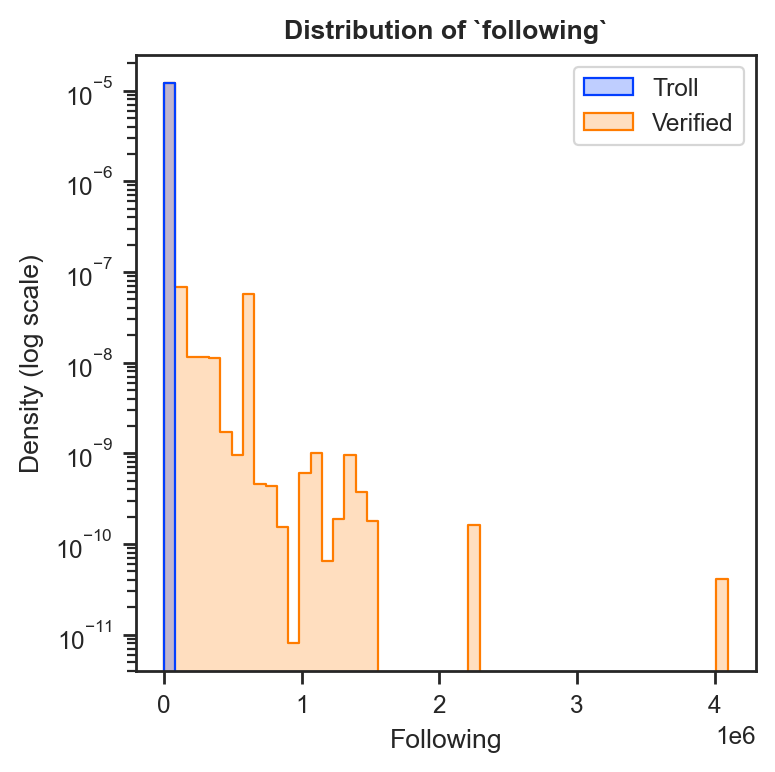

In [186]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_title("Distribution of `following`", weight='bold')
ax.set_xlabel("Following")
ax.set_ylabel("Density (log scale)")
ax.set_yscale("log")

sns.histplot(merged_df, 
                x='following', 
                hue='class',
                bins=50,
                #binrange=(0, 280),
                element='step',
                stat='density',
                common_norm=False,
                ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

In [172]:
median_following: pd.DataFrame = merged_df.groupby(['account_category'])['following'].median() \
                                .to_frame().reset_index().sort_values(by='following')

median_following

,account_category,following
0,Commercial,3.0
1,Fearmonger,65.0
5,NonEnglish,255.0
7,Unknown,515.0
3,LeftTroll,796.0
8,Verified_User,995.0
6,RightTroll,1867.0
2,HashtagGamer,2622.0
4,NewsFeed,7090.0


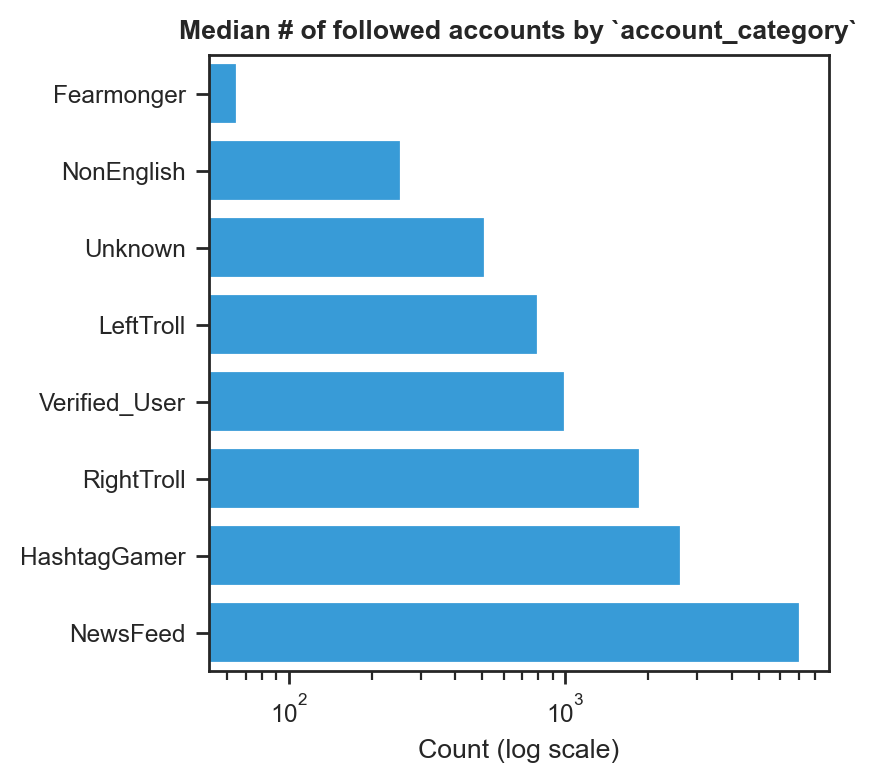

In [185]:
fig, ax = plt.subplots(figsize=(4,4))

sns.barplot(median_following.nlargest(8, columns='following').sort_values(by='following', ascending=True),
            x='following', 
            y='account_category', 
            color=twitter_colors['blue'],
            ax=ax
        )

#ax.set_xscale('log')
ax.set_title("Median # of followed accounts by `account_category`", weight='bold')
ax.set_xlabel("Count (log scale)")
ax.set_ylabel(None)
ax.set_xscale("log")

plt.show()

## 4.7 - Number of Followers (`followers`, other accounts following this one)

In [96]:
merged_df['followers'].describe()

count    3.624894e+06
mean     1.744430e+06
std      9.483849e+06
min      0.000000e+00
25%      1.140000e+03
50%      1.138500e+04
75%      5.856000e+04
max      1.335241e+08
Name: followers, dtype: float64

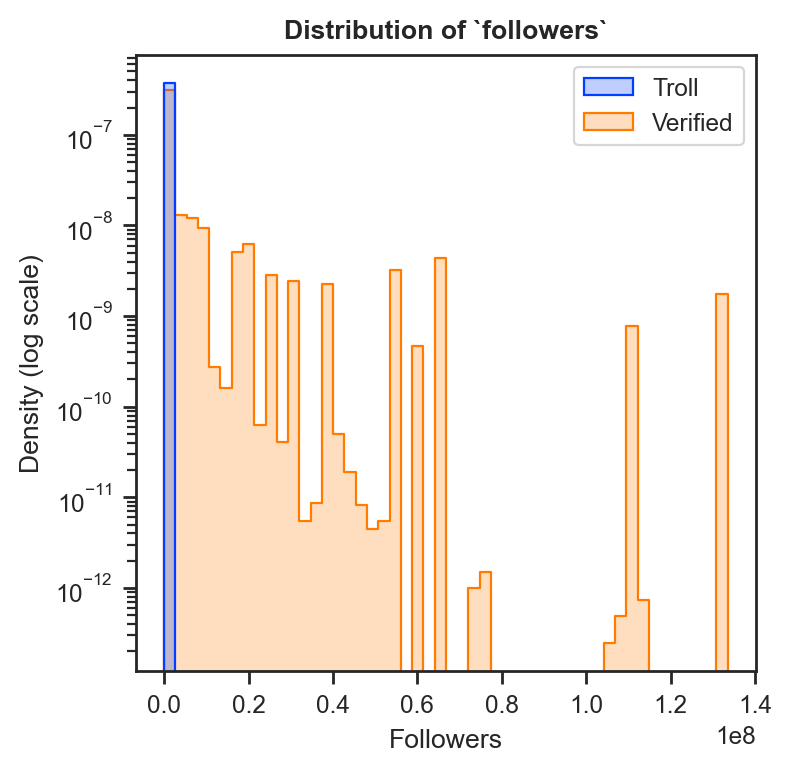

In [182]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_title("Distribution of `followers`", weight='bold')
ax.set_xlabel("Followers")
ax.set_ylabel("Density (log scale)")
ax.set_yscale("log")

sns.histplot(merged_df, 
                x='followers', 
                hue='class',
                bins=50,
                #binrange=(0, 280),
                element='step',
                stat='density',
                common_norm=False,
                ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

In [178]:
median_followers: pd.DataFrame = merged_df.groupby(['account_category'])['followers'].median() \
                                .to_frame().reset_index().sort_values(by='followers')

median_followers

,account_category,followers
1,Fearmonger,48.0
0,Commercial,262.0
5,NonEnglish,335.0
3,LeftTroll,836.0
6,RightTroll,1436.0
2,HashtagGamer,2484.0
7,Unknown,9311.0
4,NewsFeed,14725.0
8,Verified_User,81833.0


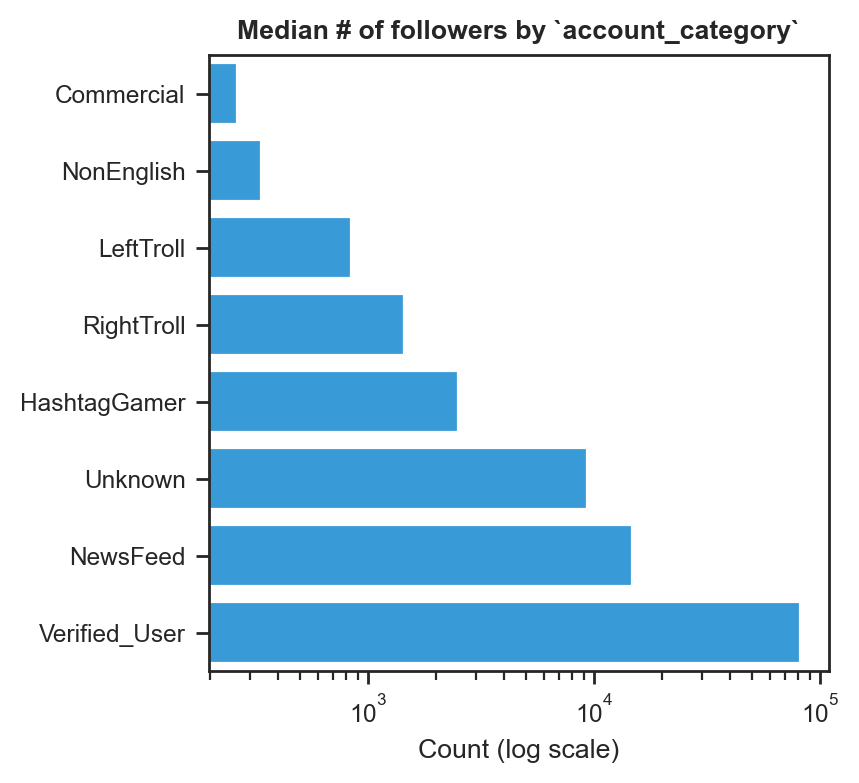

In [183]:
fig, ax = plt.subplots(figsize=(4,4))

sns.barplot(median_followers.nlargest(8, columns='followers').sort_values(by='followers', ascending=True),
            x='followers', 
            y='account_category', 
            color=twitter_colors['blue'],
            ax=ax
        )

#ax.set_xscale('log')
ax.set_title("Median # of followers by `account_category`", weight='bold')
ax.set_xlabel("Count (log scale)")
ax.set_ylabel(None)
ax.set_xscale("log")

plt.show()

## 4.8 - Number of Update Actions (`updates`)

In [189]:
merged_df['updates'].describe()

count    3.624894e+06
mean     6.779971e+03
std      1.945427e+04
min      0.000000e+00
25%      1.000000e+01
50%      1.085000e+03
75%      6.200000e+03
max      5.732199e+06
Name: updates, dtype: float64

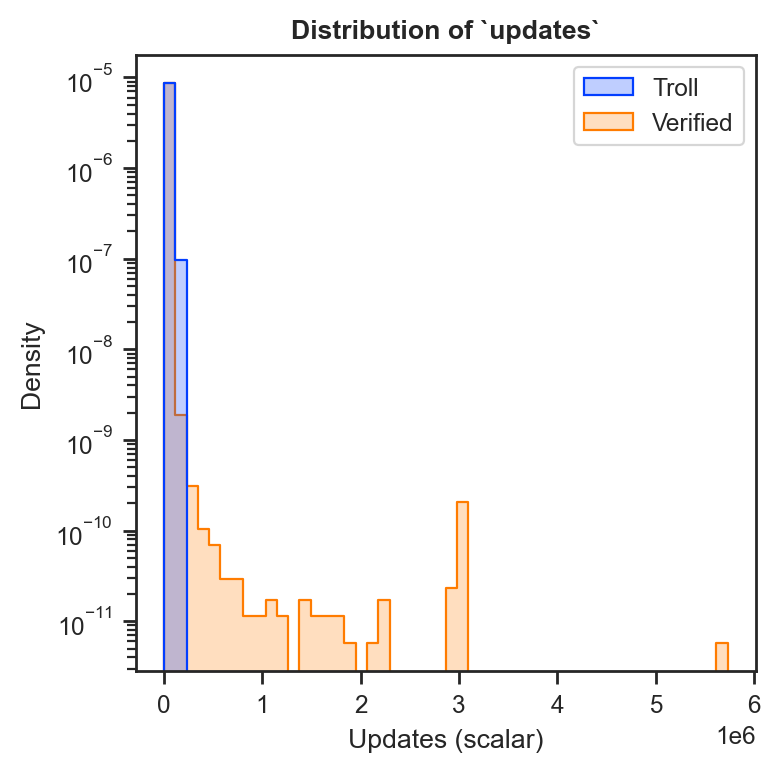

In [194]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_title("Distribution of `updates`", weight='bold')
ax.set_xlabel("Updates (scalar)")
ax.set_ylabel("Density")
ax.set_yscale("log")

sns.histplot(merged_df, 
                x='updates', 
                hue='class',
                bins=50,
                #binrange=(0, 280),
                element='step',
                stat='density',
                common_norm=False,
                ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

## 4.9 - Retweet (`is_retweet`)

In [ ]:
#

## 4.10 - Account Category (`account_category`)

In [164]:
account_category: pd.DataFrame = merged_df['account_category'].value_counts(dropna=False, ascending=True) \
                                .to_frame().reset_index().rename(
                                    columns={'index': 'account_category', 'account_category': 'count'}
                                )

account_category

,account_category,count
0,Fearmonger,11001
1,NonEnglish,26562
2,Unknown,43252
3,Commercial,112580
4,HashtagGamer,236091
5,LeftTroll,422141
6,NewsFeed,596593
7,RightTroll,704953
8,Verified_User,1471721


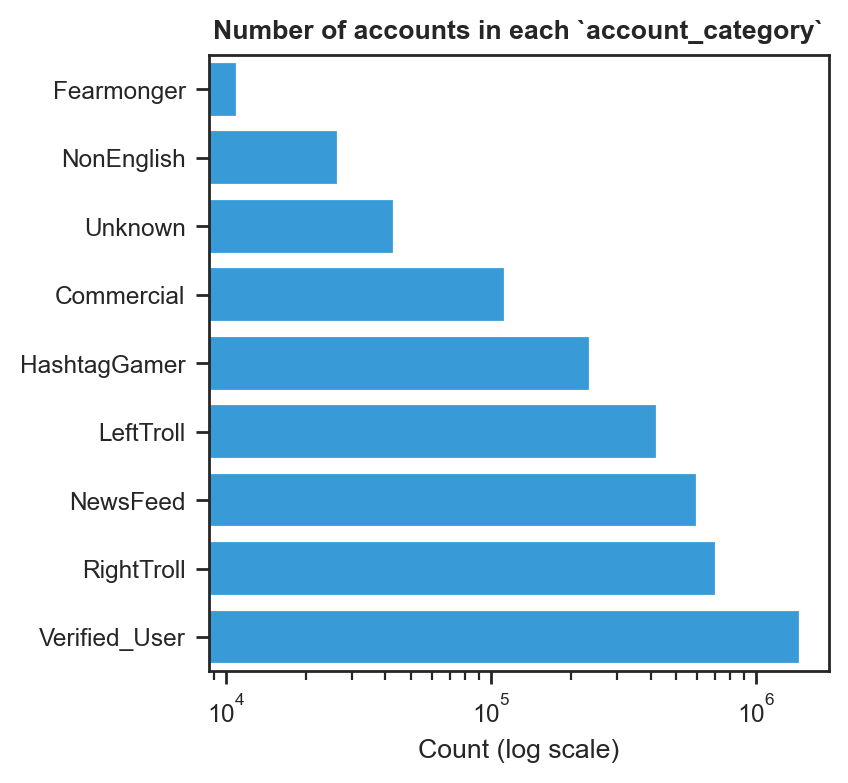

In [187]:
fig, ax = plt.subplots(figsize=(4,4))

sns.barplot(account_category,
            x='count', 
            y='account_category', 
            color=twitter_colors['blue'],
            ax=ax
        )

#ax.set_xscale('log')
ax.set_title("Number of accounts in each `account_category`", weight='bold')
ax.set_xlabel("Count (log scale)")
ax.set_ylabel(None)
ax.set_xscale("log")

plt.show()

## 4.11 - Tweet ID (`tweet_id`)

In [ ]:
#

## 4.12 - First URL from within Tweet Content (`tco1_step1`)

In [ ]:
#

## 4.13 - Data Source (`data_source`)

In [ ]:
#

## 4.14 - Tweet Has URL (`has_url`)

In [ ]:
#

## 4.15 - Emoji Text (`emoji_text`)

In [ ]:
#

## 4.16 - Number of Emoji (`emoji_count`)

In [ ]:
#

## 4.17 - Publish Date of Tweet (`publish_date`)

In [87]:
# determine timeline of tweets
min_time = merged_df['publish_date'].min()
max_time = merged_df['publish_date'].max()

print(f"TIMELINE: {min_time:%Y-%m-%d %H:%M} to {max_time:%Y-%m-%d %H:%M}")

TIMELINE: 2013-01-01 00:01 to 2017-12-30 23:57


# 5 - Features (Composite Analysis)

## 5.1 - Following Ratio

In [199]:
merged_df['following_ratio'] = (merged_df['following'] + 0) / (merged_df['followers'] + 1)

merged_df['following_ratio'].describe()

count    3.624894e+06
mean     9.045287e-01
std      4.824604e+00
min      0.000000e+00
25%      1.562500e-02
50%      3.870923e-01
75%      9.384776e-01
max      1.010000e+03
Name: following_ratio, dtype: float64

<AxesSubplot: title={'center': ' Median following ratio by account category'}, ylabel='account_category'>

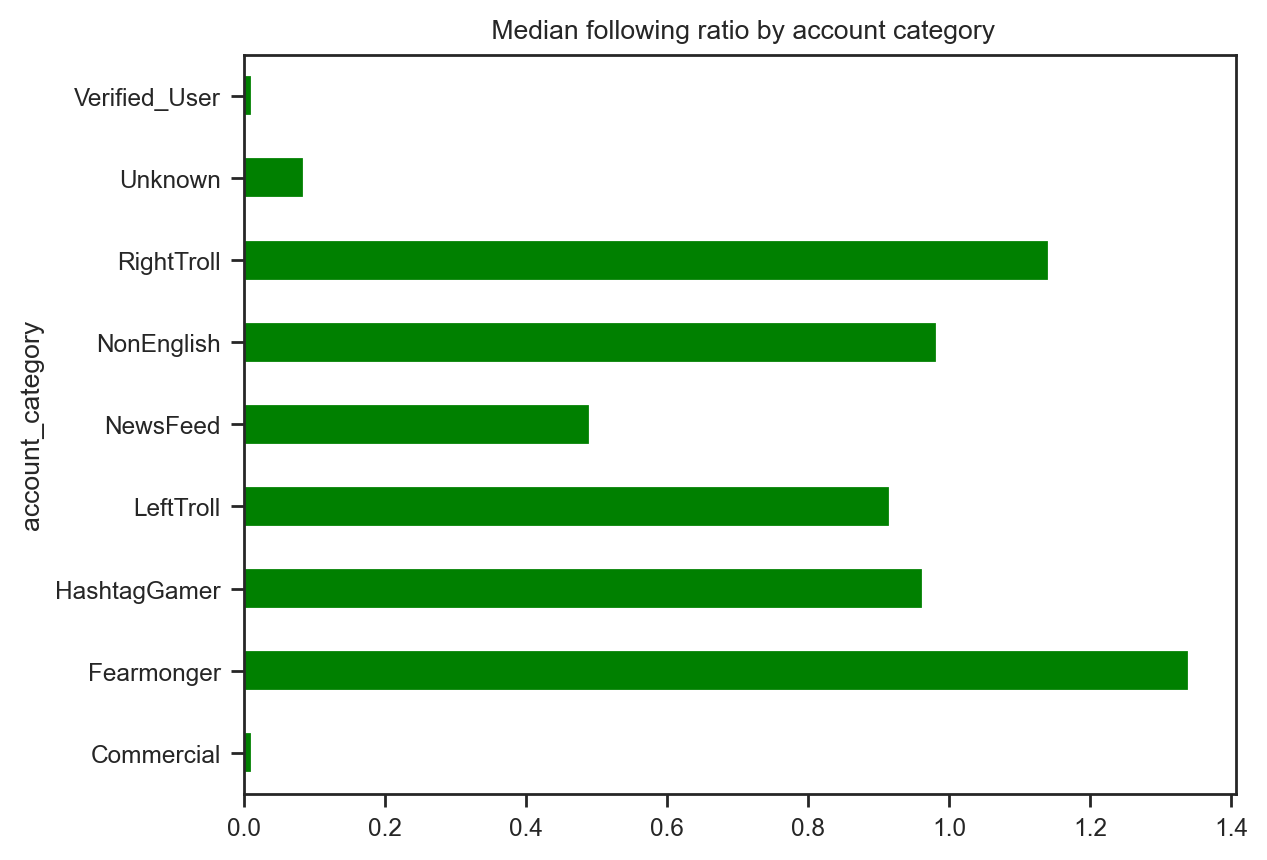

In [201]:
merged_df.groupby(['account_category'])['following_ratio'].median()\
    .plot(kind='barh', title=' Median following ratio by account category', color = 'green')

<AxesSubplot: title={'center': 'Mean following ratio by account category'}, ylabel='account_category'>

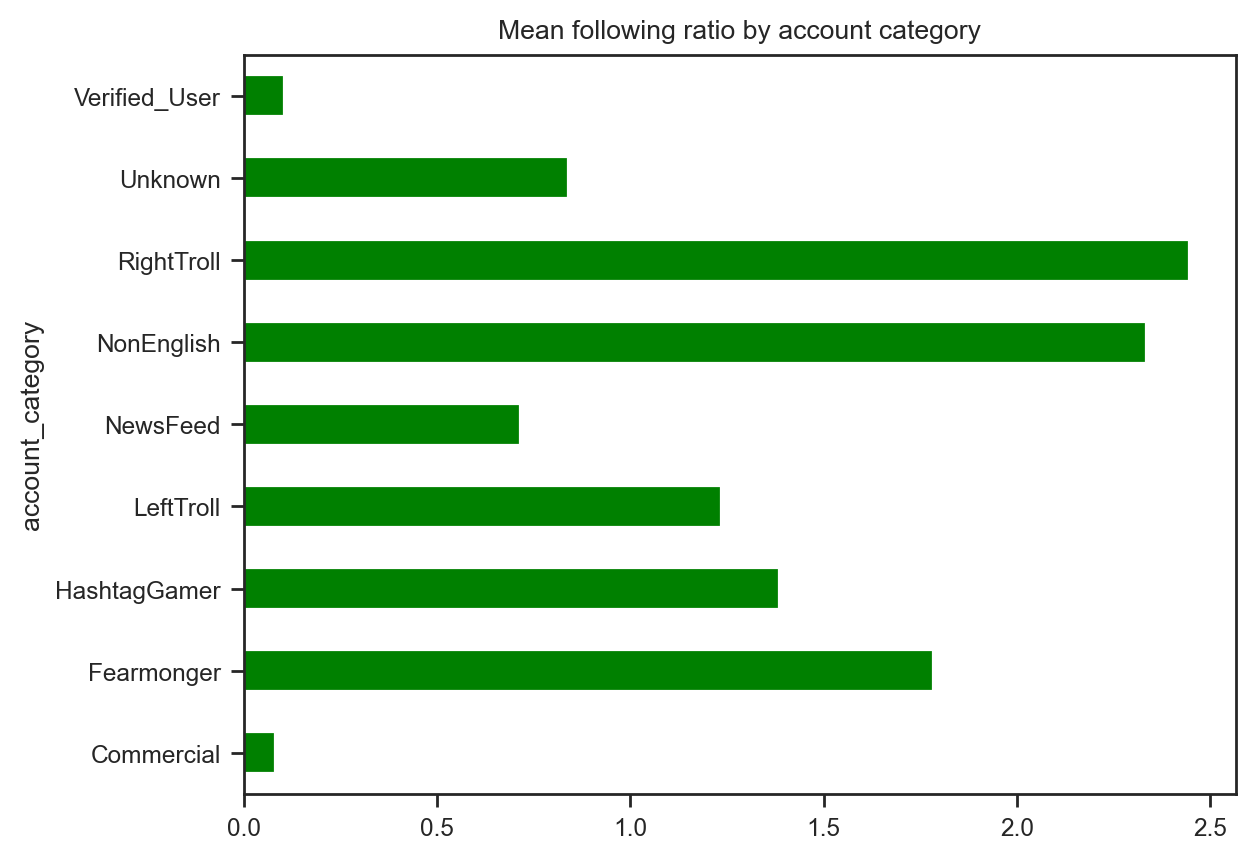

In [205]:
merged_df.groupby(['account_category'])['following_ratio'].mean() \
    .plot(kind='barh',title='Mean following ratio by account category', color = 'green')

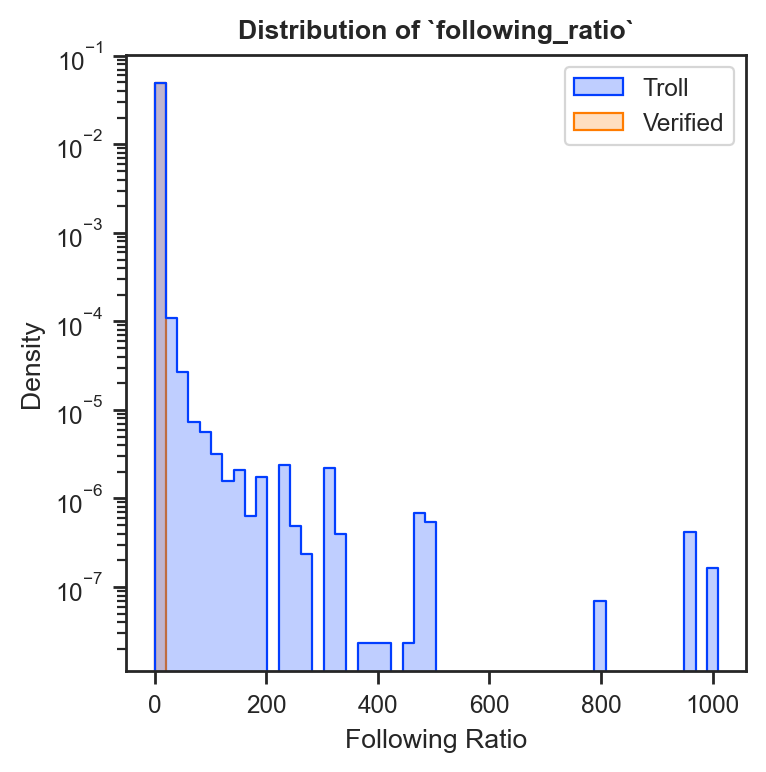

In [204]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_title("Distribution of `following_ratio`", weight='bold')
ax.set_xlabel("Following Ratio")
ax.set_ylabel("Density")
ax.set_yscale("log")

sns.histplot(merged_df, 
                x='following_ratio', 
                hue='class',
                bins=50,
                #binrange=(0, 280),
                element='step',
                stat='density',
                common_norm=False,
                ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

## 5.2 - Average Tweets per Author

Note this is not representative of the entire population of Tweets, only of our dataset's sample of tweets/authors.

In [106]:
avg_tweets_per_author: float = len(merged_df.index) / merged_df['author'].nunique()

print(f"Average tweets per author (in dataset):\t{avg_tweets_per_author:0.1f} tweets/author")

Average tweets per author (in dataset):	25.5 tweets/author
